# Autoencoder Code

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
from scipy.io import wavfile 
from PIL import Image  
import cv2
import os
import matplotlib.pyplot as plt
import cv2
from skimage.util import *


epochs = 10

img_data_array=[]
filenames = []
train_data_array = []
test_data_array = []

for file in os.listdir(os.path.join('/content/data/')):
  if file.startswith('.'):
    continue
  filenames.append(file)

split_1 = int(0.60 * len(filenames))
split_2 = int(0.40* len(filenames))
train_filenames = filenames[:split_1]
test_filenames = filenames[split_2:]

for file in os.listdir(os.path.join('/content/data/')):
  if file.startswith('.') or file not in train_filenames:
    continue
  img = Image.open('/content/data/' +file)
  numpydata = np.asarray(img)
  train_data_array.append(numpydata)

for l in train_data_array:
  x_train = l.astype('float32') / 255.
  x_train = x_train[..., tf.newaxis] 

for file in os.listdir(os.path.join('/content/data/')):
  if file.startswith('.') or file not in test_filenames:
    continue
  img = Image.open('/content/data/'+file)
  numpydata = np.asarray(img)
  test_data_array.append(numpydata)

for l in test_data_array:
  x_test = l.astype('float32') / 255.
  x_test = x_test[..., tf.newaxis]

'''print("train:\n{}".format(train_data_array))
print("test:\n{}".format(test_data_array))
print(x_train.shape)
print(x_test.shape)'''


noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) 
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)
'''#x_train_noisy = random_noise(x_train, mode='gaussian', mean=0, var=0.5**2)
#x_train_noisy = random_noise(x_train, mode='speckle', mean=0.2, var=0.8**2)
#x_train_noisy = random_noise(x_train, mode='s&p', amount=0.4)
#x_test_noisy = random_noise(x_test, mode='gaussian', mean=0, var=0.5**2)
#x_test_noisy = random_noise(x_test, mode='speckle', mean=0.2, var=0.8**2)
#x_test_noisy = random_noise(x_test, mode='s&p', amount=0.4)'''



n = 4
plt.figure(figsize=(20, 8))
plt.gray()

for i in range(n):
  ax = plt.subplot(2, n, i + 1) 
  plt.title("original", size=20) 
  plt.imshow(tf.squeeze(x_test)) 
  plt.gray() 
  bx = plt.subplot(2, n, n+ i + 1) 
  plt.title("original + noise", size=20) 
  plt.imshow(tf.squeeze(x_test_noisy)) 
plt.show()
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input

class NoiseReducer(tf.keras.Model): 
  def __init__(self):

    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
      #Input(shape=(772, 317, 1)),
      Input(shape=(1024, 3, 1)),
      Conv2D(16, (2,2), activation='relu', padding='same', strides=1), 
      Conv2D(8, (2,2), activation='relu', padding='same', strides=1)]) 
    
    self.decoder = tf.keras.Sequential([ 
      Conv2DTranspose(8, kernel_size=3, strides=1, activation='relu', padding='same'), 
      Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'), 
      Conv2D(1, kernel_size=(2,2), activation='sigmoid', padding='same')]) 
  
  def call(self, x): 
    encoded = self.encoder(x) 
    decoded = self.decoder(encoded) 
    return decoded

autoencoder = NoiseReducer()

if x_test.ndim == 2:
    x_test = np.expand_dims(x_test, axis=0)

if x_test_noisy.ndim == 2:
    x_test_noisy = np.expand_dims(x_test_noisy, axis=0)


autoencoder.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

from keras.utils import to_categorical

#x_test_noisy=to_categorical(x_test_noisy)
#x_test=to_categorical(x_test)

history=autoencoder.fit(x_train_noisy, 
                x_train,
                epochs=epochs, 
                shuffle=True,
                batch_size=5,
                validation_data=(x_test_noisy, x_test))


encoded_imgs=autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)

n = 10
plt.figure(figsize=(20, 8))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(x_test_noisy)) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs)) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 

  
  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(x_test)) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False)
plt.show()

print(autoencoder.evaluate(decoded_imgs.numpy(),x_test))
print("\nModel accuracy: ", autoencoder.evaluate(decoded_imgs,x_test))
print("SSIM: {}".format(ssim(decoded_imgs.numpy(), x_test, win_size=3, multichannel=True)))
print("PSNR: {}\n".format(psnr(decoded_imgs.numpy(), x_test)))

In [ ]:
x = decoded_imgs.numpy()
#help(np.iinfo)
data = (x * 32767).astype(np.int16)
wavfile.write('/content/data/test.wav', 16000, data)

In [ ]:
sr = 16000
fs = 100
t = np.linspace(0., 1., sr)
amp = np.iinfo(np.int16).max
data = amp * np.sin(2. * np.pi * fs * t)
wavfile.write("/content/data/eg.wav", sr, data)

# Signal to STFT and back

In [ ]:
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
%matplotlib inline

def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

wav_loc = "/content/data/sub_delay_1000ms.wav"
rate, data = wavfile.read(wav_loc)
data = data / 32768
print(f"{data}, {rate}")

IPython.display.Audio(data=data, rate=rate)

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(data)

In [ ]:
n_fft, win_length, hop_length = 2048, 2048, 512
data_stft = librosa.stft(y=data, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
data_stft_db = librosa.core.amplitude_to_db(np.abs(data_stft), ref=1.0, amin=1e-20, top_db=80.0)
plot_spectrogram(data_stft_db, title="STFT Signal")

data_stft_from_db = librosa.core.db_to_amplitude(data_stft_db, ref=1.0)
data_from_stft = librosa.istft(data_stft_from_db, hop_length=hop_length, win_length=win_length)
recovered_spec = librosa.core.amplitude_to_db(np.abs(librosa.stft(data_from_stft, n_fft, hop_length, win_length)))
plot_spectrogram(recovered_spec, title="Inverse STFT Signal")

In [ ]:
IPython.display.Audio(data=data_from_stft, rate=16000)

In [ ]:
data_stft_db.shape

# Updated Autoencoder Code

In [ ]:
import os
import cv2
import librosa
import IPython
import numpy as np
import scipy.signal
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from skimage.util import *
from scipy.io import wavfile
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, InputLayer

%matplotlib inline

def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

clean_wav_loc = "/content/data/combined.wav"#listener.wav"
noisy_wav_loc = "/content/data/listener.wav"#combined.wav"
clean_rate, clean_data = wavfile.read(clean_wav_loc)
noisy_rate, noisy_data = wavfile.read(noisy_wav_loc)
clean_data = clean_data / 32768
noisy_data = noisy_data / 32768
print(f"Clean: {clean_data}, {clean_rate}")
print(f"Noisy: {noisy_data}, {noisy_rate}")

In [ ]:
n_fft, win_length, hop_length = 2048, 2048, 512
clean_data_stft = librosa.stft(y=clean_data, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
clean_data_stft_db = librosa.core.amplitude_to_db(np.abs(clean_data_stft), ref=1.0, amin=1e-20, top_db=80.0)
noisy_data_stft = librosa.stft(y=noisy_data, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
noisy_data_stft_db = librosa.core.amplitude_to_db(np.abs(noisy_data_stft), ref=1.0, amin=1e-20, top_db=80.0)

In [ ]:
clean_data_stft_db = clean_data_stft_db.reshape(1, 1025, 148, 1)
noisy_data_stft_db = noisy_data_stft_db.reshape(1, 1025, 148, 1)

In [ ]:
class NoiseReducer(tf.keras.Model): 
  def __init__(self):

    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
      #Input(shape=(772, 317, 1)),
      InputLayer(input_shape=(1025, 148, 1)),
      Conv2D(16, (2,2), activation='relu', padding='same', strides=1), 
      Conv2D(8, (2,2), activation='relu', padding='same', strides=1)]) 
    
    self.decoder = tf.keras.Sequential([ 
      Conv2DTranspose(8, kernel_size=2, strides=1, activation='relu', padding='same'), 
      Conv2DTranspose(16, kernel_size=2, strides=1, activation='relu', padding='same'), 
      Conv2D(1, kernel_size=(2,2), activation='sigmoid', padding='same')]) 
  
  def call(self, x): 
    encoded = self.encoder(x) 
    decoded = self.decoder(encoded) 
    return decoded

autoencoder = NoiseReducer()

autoencoder.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = autoencoder.fit(noisy_data_stft_db,
                          clean_data_stft_db,
                          epochs=10,
                          shuffle=True,
                          batch_size=5,
                          validation_data=(noisy_data_stft_db, clean_data_stft_db))#(x_test_noisy, x_test))

In [ ]:
encoded_imgs=autoencoder.encoder(noisy_data_stft_db)#.numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)

In [ ]:
print(autoencoder.evaluate(decoded_imgs.numpy(),clean_data_stft_db))
print("\nModel accuracy: ", autoencoder.evaluate(decoded_imgs,clean_data_stft_db))
#print("SSIM: {}".format(ssim(decoded_imgs.numpy(), clean_data_stft_db, win_size=3, multichannel=True)))
#print("PSNR: {}\n".format(psnr(decoded_imgs.numpy(), clean_data_stft_db)))

In [ ]:
recovered_stft_db = decoded_imgs.numpy()
clean_data_stft_db = clean_data_stft_db.reshape(1025, 148)
noisy_data_stft_db = noisy_data_stft_db.reshape(1025, 148)
recovered_stft_db = recovered_stft_db.reshape(1025, 148)
recovered_stft = librosa.core.db_to_amplitude(recovered_stft_db, ref=1.0)
recovered = librosa.istft(recovered_stft, hop_length=hop_length, win_length=win_length)

In [ ]:
IPython.display.Audio(data=clean_data, rate=clean_rate)

In [ ]:
IPython.display.Audio(data=noisy_data, rate=noisy_rate)

In [ ]:
IPython.display.Audio(data=recovered, rate=noisy_rate)

In [ ]:
plot_spectrogram(clean_data_stft_db, title="Clean STFT Signal")
plot_spectrogram(noisy_data_stft_db, title="Noisy STFT Signal")
plot_spectrogram(recovered_stft_db, title="Recovered STFT Signal")

# Testing Area

In [12]:
import os
import cv2
import librosa
import IPython
import numpy as np
import scipy.signal
import adaptfilt as adf
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from skimage.util import *
from scipy.io import wavfile
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, InputLayer

%matplotlib inline

def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

In [13]:
step = 0.04
M = 45
sfs, u = wavfile.read("C:/Users/ashwi/Desktop/College/Sem-8/Final-Project/Audio-Samples/sender.wav")
lfs, v = wavfile.read("C:/Users/ashwi/Desktop/College/Sem-8/Final-Project/Audio-Samples/listener.wav")

u = np.frombuffer(u, np.int16)
u = np.float64(u)
v = np.frombuffer(v, np.int16)
v = np.float64(v)

coeffs = np.concatenate(([0.8], np.zeros(8), [-0.7], np.zeros(9),
                         [0.5], np.zeros(11), [-0.3], np.zeros(3),
                         [0.1], np.zeros(20), [-0.05]))

d = np.convolve(u, coeffs)
d = d/20.0
v = v/20.0
d = d[:len(v)]
d = d + v - (d*v)/256.0
d = np.round(d,0)

y, e, w = adf.nlms(u[:len(d)], d, M, step, returnCoeffs=True)

In [14]:
clean_wav_loc = "C:/Users/ashwi/Desktop/College/Sem-8/Final-Project/Audio-Samples/listener.wav"
#noisy_wav_loc = "C:/Users/ashwi/Desktop/College/Sem-8/Final-Project/Audio-Samples/combined2.wav"
clean_rate, clean_data = wavfile.read(clean_wav_loc)
noisy_rate = 16000#noisy_rate, noisy_data = wavfile.read(noisy_wav_loc)
noisy_data = e
clean_data = clean_data / 32768
#noisy_data = noisy_data / 32768
'''clean_data = np.frombuffer(clean_data, np.int16)
clean_data = np.float64(clean_data)
noisy_data = np.frombuffer(noisy_data, np.int16)
noisy_data = np.float64(noisy_data)'''
print(f"Clean: {clean_data}, {clean_rate}")
print(f"Noisy: {noisy_data}, {noisy_rate}")

Clean: [0.         0.         0.         ... 0.00537109 0.00415039 0.00396729], 16000
Noisy: [0.         0.         0.         ... 9.36820356 7.39589557 5.78340178], 16000


In [15]:
n_fft, win_length, hop_length = 2048, 2048, 512
clean_data_stft = librosa.stft(y=clean_data, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
clean_data_stft_db = librosa.core.amplitude_to_db(np.abs(clean_data_stft), ref=1.0, amin=1e-20, top_db=80.0)
noisy_data_stft = librosa.stft(y=noisy_data, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
noisy_data_stft_db = librosa.core.amplitude_to_db(np.abs(noisy_data_stft), ref=1.0, amin=1e-20, top_db=80.0)

In [17]:
clean_data_stft_db = clean_data_stft_db.reshape(1, 1025, 148, 1)
noisy_data_stft_db = noisy_data_stft_db.reshape(1, 1025, 148, 1)

In [18]:
class NoiseReducer(tf.keras.Model): 
  def __init__(self):

    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
      #Input(shape=(772, 317, 1)),
      InputLayer(input_shape=(1025, 148, 1)),
      Conv2D(16, (2,2), activation='relu', padding='same', strides=1), 
      Conv2D(8, (2,2), activation='relu', padding='same', strides=1)]) 
    
    self.decoder = tf.keras.Sequential([ 
      Conv2DTranspose(8, kernel_size=2, strides=1, activation='relu', padding='same'), 
      Conv2DTranspose(16, kernel_size=2, strides=1, activation='relu', padding='same'), 
      Conv2D(1, kernel_size=(2,2), activation='sigmoid', padding='same')]) 
  
  def call(self, x): 
    encoded = self.encoder(x) 
    decoded = self.decoder(encoded) 
    return decoded

autoencoder = NoiseReducer()

autoencoder.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = autoencoder.fit(noisy_data_stft_db,
                          clean_data_stft_db,
                          epochs=25,
                          shuffle=True,
                          batch_size=5,
                          validation_data=(noisy_data_stft_db, clean_data_stft_db))#(x_test_noisy, x_test))

Epoch 1/25
1/1 [==============================] - 0s 242ms/step - loss: -59.7775 - accuracy: 0.0000e+00 - val_loss: -98.2999 - val_accuracy: 0.0000e+00
Epoch 2/25
1/1 [==============================] - 0s 115ms/step - loss: -98.2999 - accuracy: 0.0000e+00 - val_loss: -135.5979 - val_accuracy: 0.0000e+00
Epoch 3/25
1/1 [==============================] - 0s 112ms/step - loss: -135.5979 - accuracy: 0.0000e+00 - val_loss: -179.5546 - val_accuracy: 0.0000e+00
Epoch 4/25
1/1 [==============================] - 0s 129ms/step - loss: -179.5546 - accuracy: 0.0000e+00 - val_loss: -231.3667 - val_accuracy: 0.0000e+00
Epoch 5/25
1/1 [==============================] - 0s 135ms/step - loss: -231.3667 - accuracy: 0.0000e+00 - val_loss: -284.1468 - val_accuracy: 0.0000e+00
Epoch 6/25
1/1 [==============================] - 0s 116ms/step - loss: -284.1468 - accuracy: 0.0000e+00 - val_loss: -338.3155 - val_accuracy: 0.0000e+00
Epoch 7/25
1/1 [==============================] - 0s 134ms/step - loss: -338.31

In [19]:
encoded_imgs=autoencoder.encoder(noisy_data_stft_db)#.numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)

In [20]:
print(autoencoder.evaluate(decoded_imgs.numpy(),clean_data_stft_db))
print("\nModel accuracy: ", autoencoder.evaluate(decoded_imgs,clean_data_stft_db))
#print("SSIM: {}".format(ssim(decoded_imgs.numpy(), clean_data_stft_db, win_size=3, multichannel=True)))
#print("PSNR: {}\n".format(psnr(decoded_imgs.numpy(), clean_data_stft_db)))

1/1 [==============================] - 0s 4ms/step - loss: -7.2171 - accuracy: 0.0000e+00
[-7.2170820236206055, 0.0]
1/1 [==============================] - 0s 5ms/step - loss: -7.2171 - accuracy: 0.0000e+00

Model accuracy:  [-7.2170820236206055, 0.0]


In [21]:
recovered_stft_db = decoded_imgs.numpy()
clean_data_stft_db = clean_data_stft_db.reshape(1025, 148)
noisy_data_stft_db = noisy_data_stft_db.reshape(1025, 148)
recovered_stft_db = recovered_stft_db.reshape(1025, 148)
recovered_stft = librosa.core.db_to_amplitude(recovered_stft_db, ref=1.0)
recovered = librosa.istft(recovered_stft, hop_length=hop_length, win_length=win_length)

In [ ]:
IPython.display.Audio(data=clean_data, rate=clean_rate)

In [ ]:
IPython.display.Audio(data=noisy_data, rate=noisy_rate)

In [ ]:
IPython.display.Audio(data=recovered, rate=noisy_rate)

In [22]:
cd = clean_data.astype('int16')
nd = noisy_data.astype('int16')
rd = recovered.astype('int16')
wavfile.write("C:/Users/ashwi/Desktop/College/Sem-8/Final-Project/Audio-Samples/AE-Output/clean.wav", 16000, clean_data)
wavfile.write("C:/Users/ashwi/Desktop/College/Sem-8/Final-Project/Audio-Samples/AE-Output/noisy.wav", 16000, noisy_data)
wavfile.write("C:/Users/ashwi/Desktop/College/Sem-8/Final-Project/Audio-Samples/AE-Output/recovered.wav", 16000, recovered)

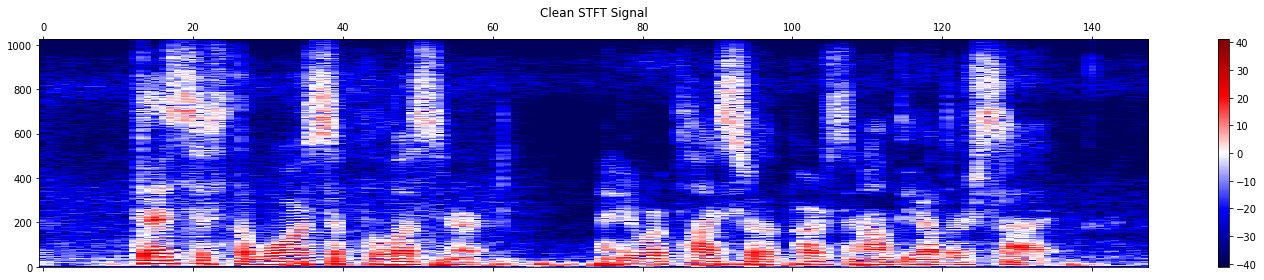

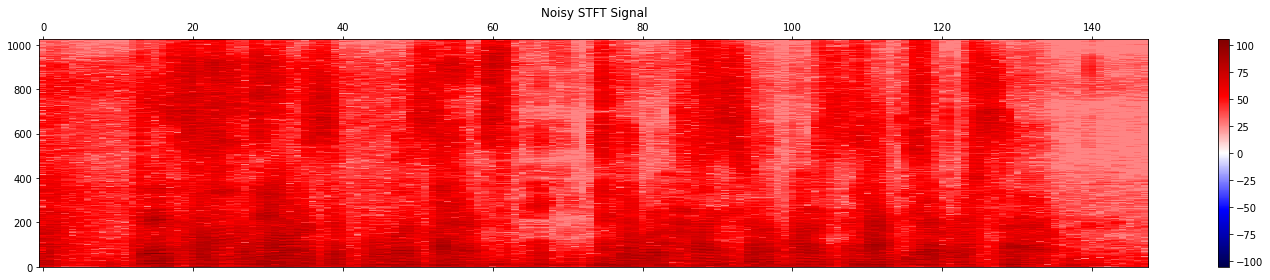

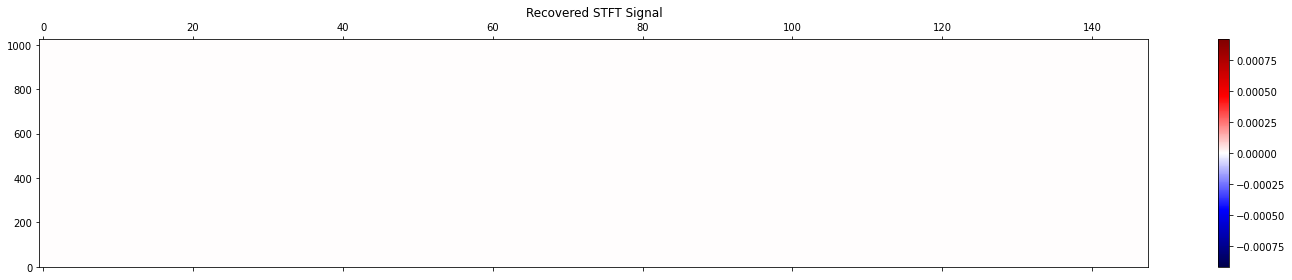

In [23]:
plot_spectrogram(clean_data_stft_db, title="Clean STFT Signal")
plot_spectrogram(noisy_data_stft_db, title="Noisy STFT Signal")
plot_spectrogram(recovered_stft_db, title="Recovered STFT Signal")

In [ ]:
#y, e, w = nlms(recovered[:len(clean_data)], clean_data, M=80, step=0.03, returnCoeffs=True)
#y, e, w = nlms(u, d, M=45, step=0.04, returnCoeffs=True)

In [ ]:
#IPython.display.Audio(data=e, rate=16000)

In [ ]:
'''mswe = mswe(w, recovered[:80])
plt.figure(2)
plt.title('Mean Squared Weight Error', fontsize=16)
plt.plot(mswe)
plt.grid()
plt.xlabel('Samples', fontsize=14, labelpad=10)
plt.ylabel('MSWE', fontsize=14, labelpad=20)
plt.show()'''

# Misc.

In [ ]:
import os
import librosa
import numpy as np
from scipy.io import wavfile

print("File\t\tSample Rate\tLength\t\tData Shape\tSTFT Shape\tSTFT DB Shape")
for file in os.listdir('/content/data/'):
  if file.endswith('.wav'):
    rate, data = wavfile.read('/content/data/'+file)
    data = data / 32768
    dataStft = librosa.stft(data)
    dataStftDb = librosa.core.amplitude_to_db(np.abs(dataStft))
    print(f"{file}\t{rate} Hz\t{round((data.shape[0]/rate), 2)} seconds\t{data.shape}\t{dataStft.shape}\t{dataStftDb.shape}")